In [2]:
# Mortality prediction mimic3c

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import FunctionTransformer

# Load dataset
df = pd.read_csv('mimic3c.csv')

# --- Step 1: Create Derived Features ---

# Interaction per day
df['interactions_per_day'] = df['TotalNumInteract'] / (df['LOSdays'] + 1)

# Lab to Medication ratio
df['lab_rx_ratio'] = df['NumLabs'] / (df['NumRx'] + 1)

# Procedure per diagnosis ratio
df['proc_diag_ratio'] = df['NumProcs'] / (df['NumDiagnosis'] + 1)

# Chart event density
df['chart_density'] = df['NumChartEvents'] / (df['LOSdays'] + 1)

# Number of unique services touched (proxy for complexity)
df['total_unique_events'] = (
    (df['NumLabs'] > 0).astype(int) +
    (df['NumMicroLabs'] > 0).astype(int) +
    (df['NumRx'] > 0).astype(int) +
    (df['NumNotes'] > 0).astype(int) +
    (df['NumProcEvents'] > 0).astype(int) +
    (df['NumChartEvents'] > 0).astype(int)
)

# High-intensity case (many notes and procedures)
df['high_intensity_flag'] = ((df['NumNotes'] > 10) & (df['NumProcs'] > 5)).astype(int)

# Binary target
df['expired'] = df['ExpiredHospital'].astype(int)

# --- Step 2: Handle Categorical Variables ---

categorical_cols = ['gender', 'admit_type', 'admit_location', 'insurance', 'religion', 'marital_status', 'ethnicity']

df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# --- Step 3: Drop Non-Useful or Redundant Columns ---

drop_cols = ['hadm_id', 'AdmitDiagnosis', 'AdmitProcedure', 'ExpiredHospital']
df.drop(columns=drop_cols, inplace=True)

# --- Step 4: Normalize Skewed Numeric Features (Log Transform) ---

skewed_cols = ['TotalNumInteract', 'interactions_per_day', 'NumChartEvents', 'NumRx']
log_transformer = FunctionTransformer(np.log1p)
df[skewed_cols] = log_transformer.fit_transform(df[skewed_cols])

# --- Final Dataset for Modeling ---

X = df.drop(columns=['expired'])
y = df['expired']


In [3]:
print("Initial dataset shape:", df.shape)
df.head()


Initial dataset shape: (58976, 105)


,age,LOSdays,NumCallouts,NumDiagnosis,NumProcs,NumCPTevents,NumInput,NumLabs,NumMicroLabs,NumNotes,...,ethnicity_PATIENT DECLINED TO ANSWER,ethnicity_PORTUGUESE,ethnicity_SOUTH AMERICAN,ethnicity_UNABLE TO OBTAIN,ethnicity_UNKNOWN/NOT SPECIFIED,ethnicity_WHITE,ethnicity_WHITE - BRAZILIAN,ethnicity_WHITE - EASTERN EUROPEAN,ethnicity_WHITE - OTHER EUROPEAN,ethnicity_WHITE - RUSSIAN
0,35,6.17,0.16,2.59,0.00,1.30,25.12,43.44,0.65,0.05,...,False,False,False,False,False,True,False,False,False,False
1,59,4.04,0.25,2.23,0.99,1.98,13.61,55.94,1.24,1.59,...,False,False,False,False,False,True,False,False,False,False
2,48,12.04,0.00,0.75,0.17,0.83,11.46,33.39,0.33,0.15,...,False,False,False,False,False,False,False,False,False,False
3,73,7.29,0.41,0.69,0.27,0.69,20.30,32.24,0.69,0.17,...,False,False,False,False,False,True,False,False,False,False
4,60,4.88,0.00,3.69,0.82,2.25,20.49,50.61,0.61,0.34,...,False,False,False,False,False,True,False,False,False,False


In [4]:
print("Missing values:\n", df.isnull().sum().sort_values(ascending=False).head(10))


Missing values:
 age             0
LOSdays         0
NumCallouts     0
NumDiagnosis    0
NumProcs        0
NumCPTevents    0
NumInput        0
NumLabs         0
NumMicroLabs    0
NumNotes        0
dtype: int64


In [5]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
age,58976.0,53.005884,26.028120,0.0,43.000000,59.000000,73.000000,89.000000
LOSdays,58976.0,10.114955,12.456231,0.0,3.710000,6.460000,11.790000,294.630000
NumCallouts,58976.0,0.099374,0.163437,0.0,0.000000,0.000000,0.160000,4.760000
NumDiagnosis,58976.0,2.675960,8.265590,0.0,0.820000,1.410000,2.400000,450.000000
NumProcs,58976.0,0.785599,3.558090,0.0,0.210000,0.420000,0.710000,275.000000
NumCPTevents,58976.0,1.074118,2.027148,0.0,0.000000,0.970000,1.560000,225.000000
NumInput,58976.0,30.379017,62.430163,0.0,4.850000,13.990000,34.360000,6825.000000
NumLabs,58976.0,46.421124,76.061561,0.0,26.980000,38.520000,50.860000,5175.000000
NumMicroLabs,58976.0,1.219913,4.236693,0.0,0.160000,0.510000,1.350000,375.000000
NumNotes,58976.0,6.464789,106.709903,0.0,0.140000,0.330000,0.770000,7500.000000


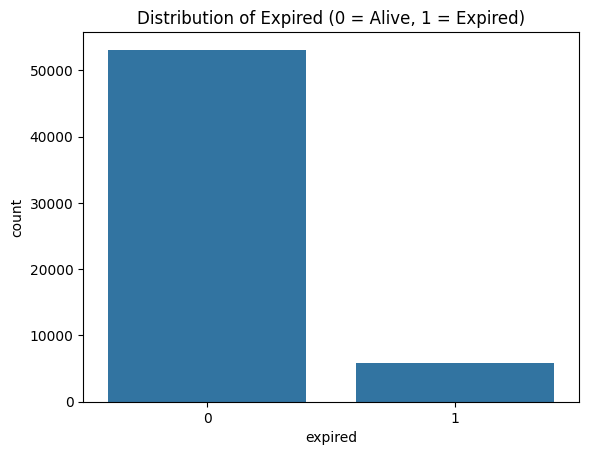

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=y)
plt.title('Distribution of Expired (0 = Alive, 1 = Expired)')
plt.show()


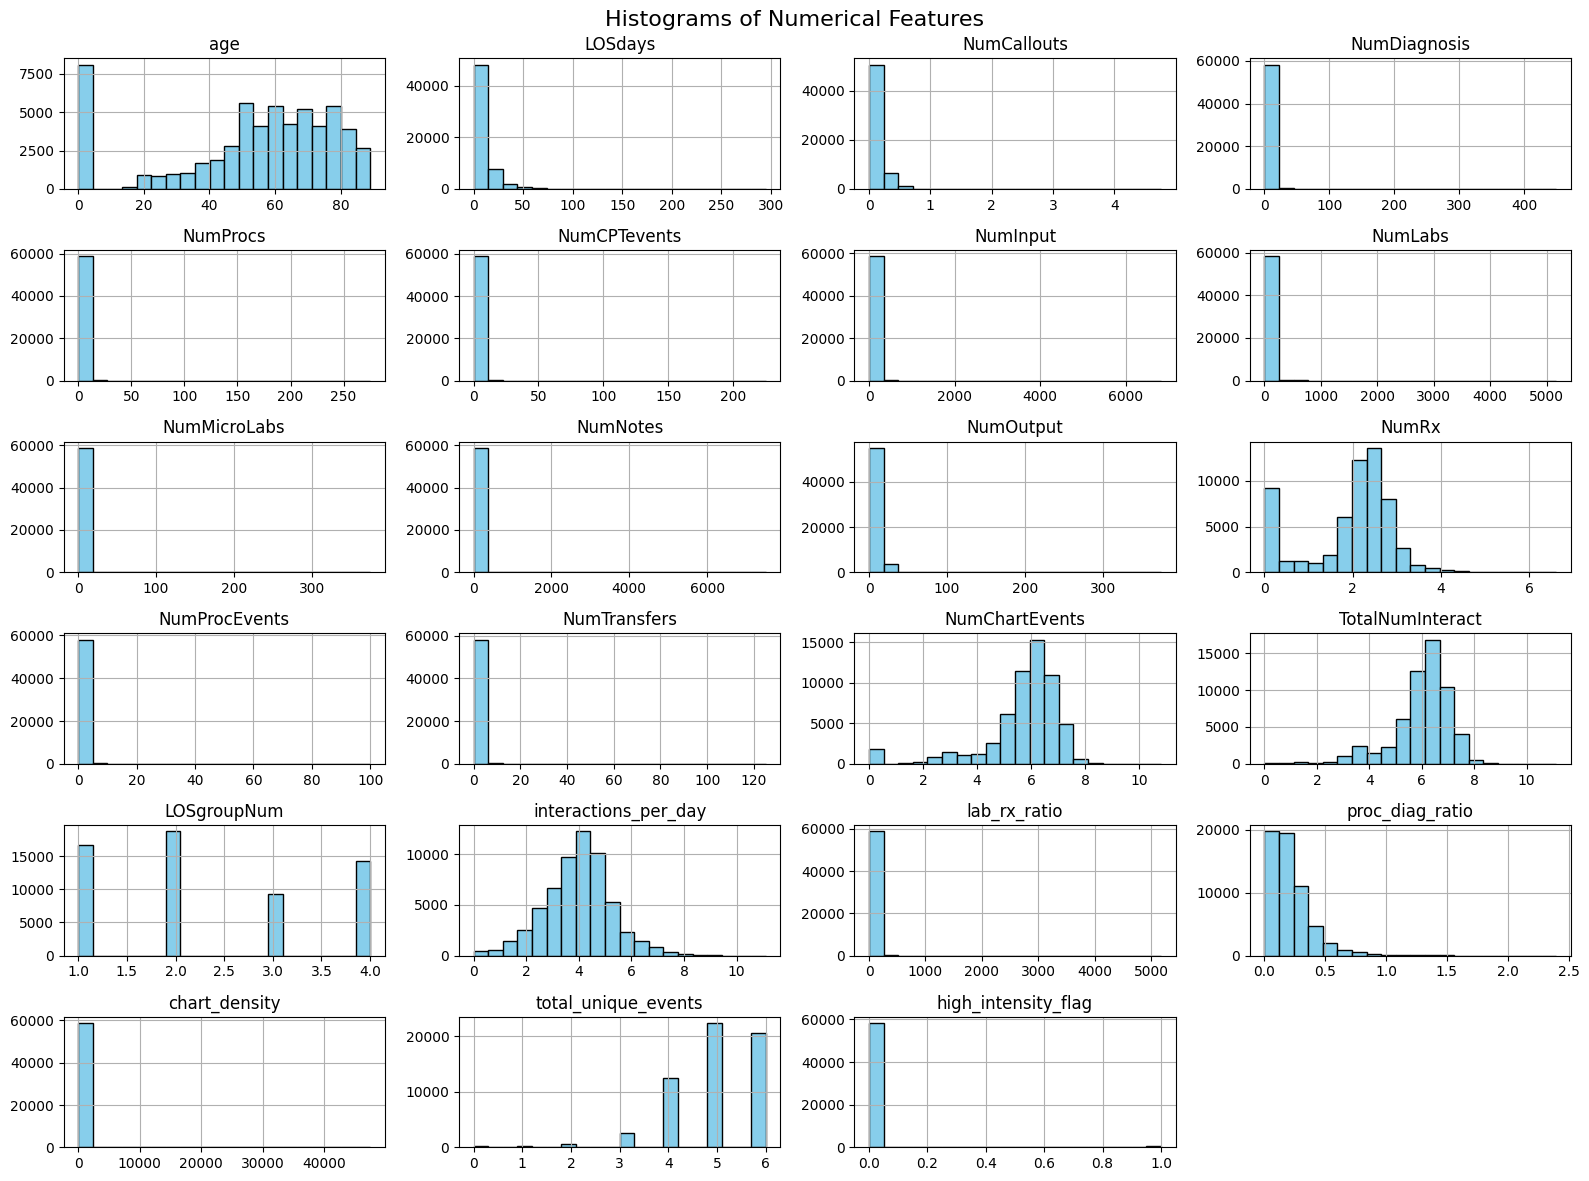

In [11]:
# --- Feature Distributions (Numerical) ---
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

X[numerical_cols].hist(bins=20, figsize=(16, 12), layout=(6, 4), color='skyblue', edgecolor='black')
plt.suptitle('Histograms of Numerical Features', fontsize=16)
plt.tight_layout()
plt.show()

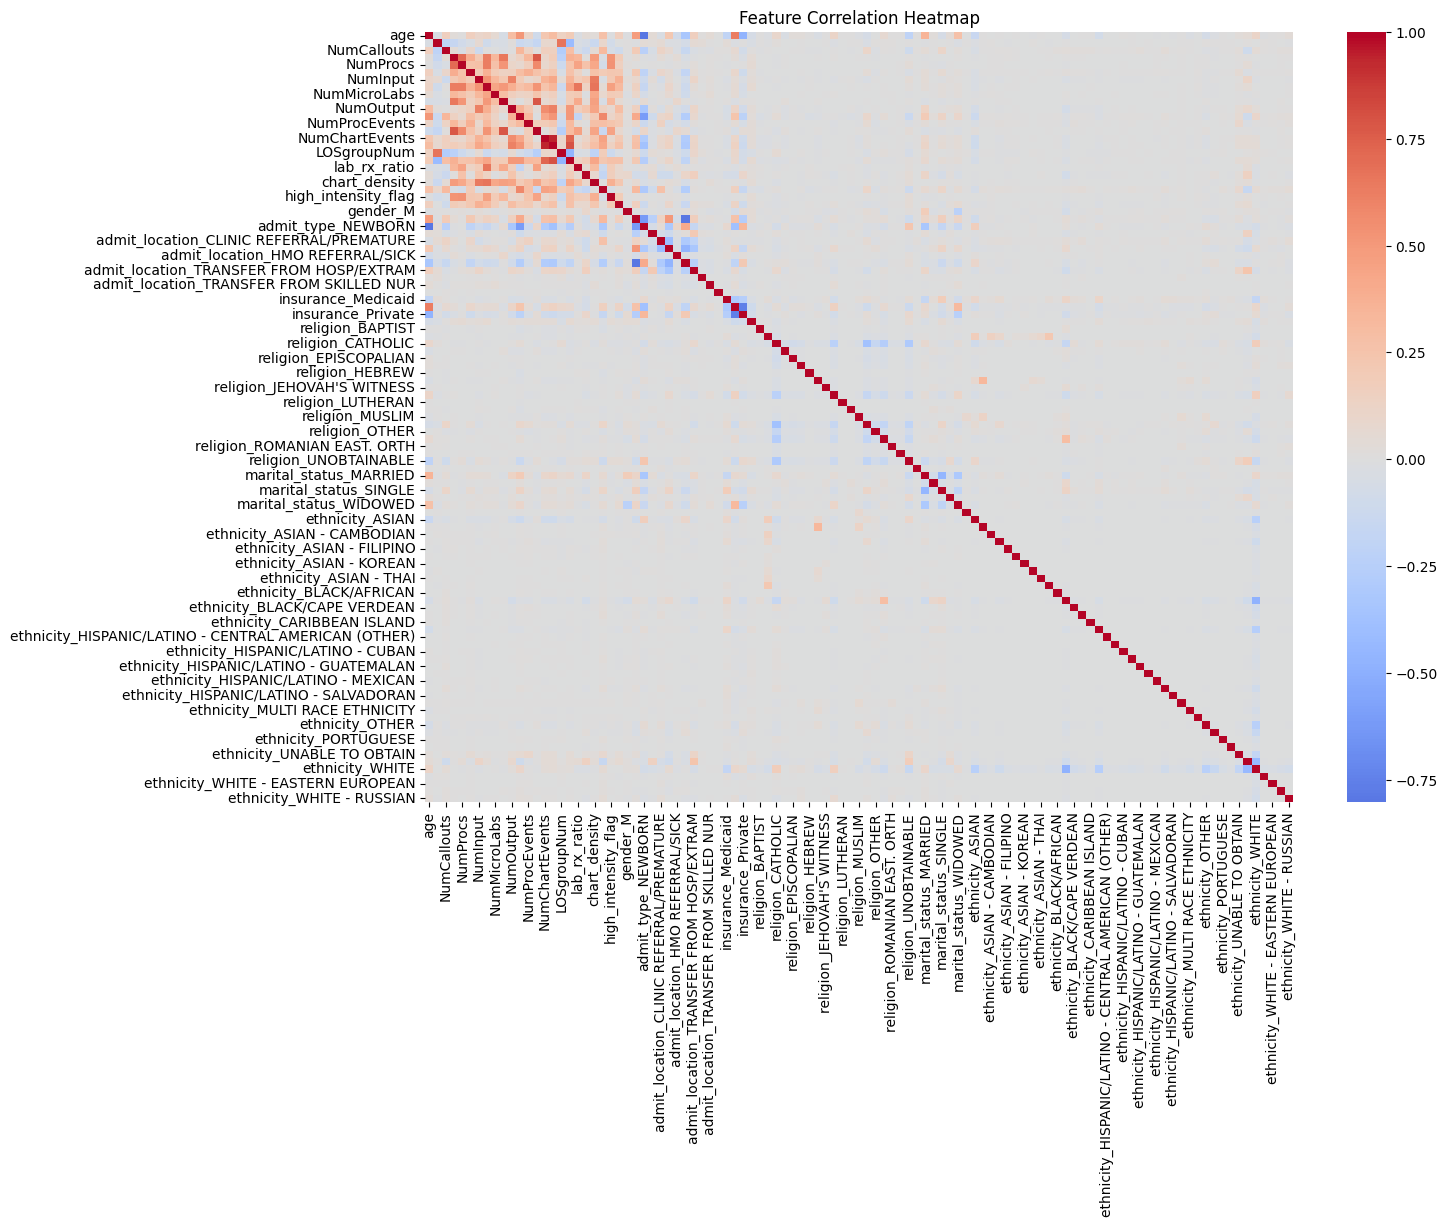

In [7]:
plt.figure(figsize=(14, 10))
sns.heatmap(df.corr(numeric_only=True), cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.show()
